<a href="https://colab.research.google.com/github/yenjia/Homework-of-Quantum2021/blob/main/HW4/quantum_HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# More QNN Layer

In [2]:
!pip install tensorflow==2.4.1
!pip install tensorflow-quantum 

In [3]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [4]:
import pandas as pd

In [5]:
tf.random.set_seed(0)

## Paper Dataset

In [6]:
df_ori = pd.read_excel("quantum_data_0609.xlsx")
df_ori = df_ori.values
df_ori[:5]

array([[3.4980695 , 0.76083467, 0.        ],
       [2.37451737, 0.77046549, 0.        ],
       [2.04440154, 0.78009631, 0.        ],
       [3.63127413, 0.78009631, 0.        ],
       [3.77027027, 0.78009631, 0.        ]])

In [7]:
data = df_ori[:,[0,1]]
data_label = df_ori[:,2]
print(data[:5])
print(data_label[:5])

[[3.4980695  0.76083467]
 [2.37451737 0.77046549]
 [2.04440154 0.78009631]
 [3.63127413 0.78009631]
 [3.77027027 0.78009631]]
[0. 0. 0. 0. 0.]


## Dataset distribution

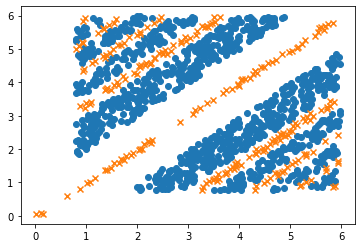

In [8]:
plt.scatter(data[data_label==0,0],data[data_label==0,1], marker='o')
plt.scatter(data[data_label==1,0],data[data_label==1,1], marker='x')

In [9]:
input_data = (data[:,0]-data[:,1])**2
input_data = input_data.flatten()
label = data_label.flatten()

idx = np.random.permutation(len(label))
input_data,label = input_data[idx], label[idx]

q0, q1 = cirq.GridQubit.rect(1, 2)
q_data =[cirq.Circuit(
        cirq.ry(i)(q0),
        cirq.ry(i)(q1)) for i in input_data] 
print(q_data[:5])
q_data = tfq.convert_to_tensor(q_data)

n = label.shape[0]//5*4
n1 = label.shape[0]//10*9
print(n)

x_train = q_data[:n]
y_train = label[:n]
x_val = q_data[n:n1]
y_val = label[n:n1]
x_test = q_data[n1:]
y_test = label[n1:]

[cirq.Circuit([
    cirq.Moment(
        cirq.Ry(rads=5.515702170807092).on(cirq.GridQubit(0, 0)),
        cirq.Ry(rads=5.515702170807092).on(cirq.GridQubit(0, 1)),
    ),
]), cirq.Circuit([
    cirq.Moment(
        cirq.Ry(rads=15.150368313425536).on(cirq.GridQubit(0, 0)),
        cirq.Ry(rads=15.150368313425536).on(cirq.GridQubit(0, 1)),
    ),
]), cirq.Circuit([
    cirq.Moment(
        cirq.Ry(rads=3.161950774487126).on(cirq.GridQubit(0, 0)),
        cirq.Ry(rads=3.161950774487126).on(cirq.GridQubit(0, 1)),
    ),
]), cirq.Circuit([
    cirq.Moment(
        cirq.Ry(rads=1.2724791327861404).on(cirq.GridQubit(0, 0)),
        cirq.Ry(rads=1.2724791327861404).on(cirq.GridQubit(0, 1)),
    ),
]), cirq.Circuit([
    cirq.Moment(
        cirq.Ry(rads=1.6370364924423182).on(cirq.GridQubit(0, 0)),
        cirq.Ry(rads=1.6370364924423182).on(cirq.GridQubit(0, 1)),
    ),
])]
964


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


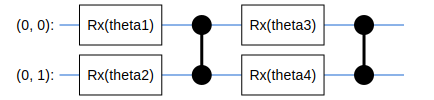

In [10]:
theta1 = sympy.Symbol('theta1')
theta2 = sympy.Symbol('theta2')
theta3 = sympy.Symbol('theta3')
theta4 = sympy.Symbol('theta4')
circuit = cirq.Circuit(
    cirq.rx(theta1).on(q0),
    cirq.rx(theta2).on(q1), cirq.CZ(q0, q1),
    cirq.rx(theta3).on(q0),
    cirq.rx(theta4).on(q1), cirq.CZ(q0, q1))
SVGCircuit(circuit)

In [11]:
# 建立量子層和經典全連接層
q_layer = tfq.layers.PQC(circuit, [cirq.Z(q0), cirq.Z(q1)])
dense_layer = tf.keras.layers.Dense(1, activation="sigmoid")
# 使用Keras建立訓練流程。量子資料首先通過PQC，然後通過經典的全連接模型
q_data_input = tf.keras.Input(shape=() ,dtype=tf.dtypes.string)
expectation_output = q_layer(q_data_input)
classifier_output = dense_layer(expectation_output)

model = tf.keras.Model(inputs=q_data_input, outputs=classifier_output)
print(model.summary())
# 編譯模型，指定優化器、損失函數和評估指標，並進行訓練
model.compile(
    optimizer = "adam",
    loss = "mse",
    metrics=['accuracy','AUC']
)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
pqc (PQC)                    (None, 2)                 4         
_________________________________________________________________
dense (Dense)                (None, 1)                 3         
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
model.fit(x=x_train, y=y_train, epochs=100,validation_data=(x_val,y_val))

# 輸出量子層參數（即theta）的訓練結果
print(q_layer.get_weights())

Epoch 1/100
31/31 [==============================] - 4s 32ms/step - loss: 0.2233 - accuracy: 0.8343 - auc: 0.9942 - val_loss: 0.2145 - val_accuracy: 0.8621 - val_auc: 1.0000
Epoch 2/100
31/31 [==============================] - 0s 11ms/step - loss: 0.2119 - accuracy: 0.8652 - auc: 0.9937 - val_loss: 0.2053 - val_accuracy: 0.8793 - val_auc: 1.0000
Epoch 3/100
31/31 [==============================] - 0s 11ms/step - loss: 0.2042 - accuracy: 0.8630 - auc: 0.9953 - val_loss: 0.1958 - val_accuracy: 0.8966 - val_auc: 1.0000
Epoch 4/100
31/31 [==============================] - 0s 11ms/step - loss: 0.1924 - accuracy: 0.8837 - auc: 0.9966 - val_loss: 0.1863 - val_accuracy: 0.9138 - val_auc: 1.0000
Epoch 5/100
31/31 [==============================] - 0s 11ms/step - loss: 0.1830 - accuracy: 0.8979 - auc: 0.9947 - val_loss: 0.1769 - val_accuracy: 0.9224 - val_auc: 1.0000
Epoch 6/100
31/31 [==============================] - 0s 11ms/step - loss: 0.1741 - accuracy: 0.8934 - auc: 0.9950 - val_loss: 0.16

In [13]:
print("Evaluate on test data")
results = model.evaluate(x_test, y_test)
print("test loss, test acc, test AUC:", results)

Evaluate on test data
5/5 [==============================] - 0s 6ms/step - loss: 0.0291 - accuracy: 1.0000 - auc: 1.0000
test loss, test acc, test AUC: [0.029142633080482483, 1.0, 1.0]


In [14]:
grid = 30
x_cor = 0
y_cor = 6
x_axis = np.linspace(x_cor,y_cor,grid)
y_axis = np.linspace(x_cor,y_cor,grid)
tmp = np.zeros((grid**2,3))
count = 0
for i in x_axis:
  for j in y_axis:
    z = (i-j)**2
    label_z = int(model.predict(tfq.convert_to_tensor([cirq.Circuit(cirq.ry(z)(q0),cirq.ry(z)(q1))])) > 0.5)
    tmp[count,:] = np.array([i,j,label_z])
    count += 1
    if count % 100 == 0:
      print(count)

100
200
300
400
500
600
700
800
900


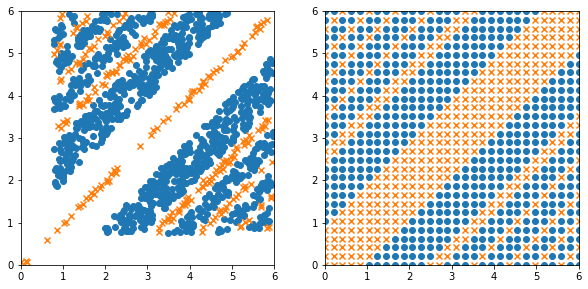

In [15]:
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.scatter(data[data_label==0,0],data[data_label==0,1], marker='o')
plt.scatter(data[data_label==1,0],data[data_label==1,1], marker='x')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(x_cor, y_cor)
plt.ylim(x_cor, y_cor)
plt.subplot(122)
plt.scatter(tmp[tmp[:,2]==0,0],tmp[tmp[:,2]==0,1], marker='o')
plt.scatter(tmp[tmp[:,2]==1,0],tmp[tmp[:,2]==1,1], marker='x')
plt.xlim(x_cor, y_cor)
plt.ylim(x_cor, y_cor)
plt.gca().set_aspect('equal', adjustable='box')

In [16]:
y_pred = (model.predict(x_test) > 0.5).astype(np.int)
# print(y_pred)
tf.math.confusion_matrix(y_pred,y_test)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[103,   0],
       [  0,  26]], dtype=int32)>